In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# read all the words
words = open("../names.txt", 'r').read().split('\n')
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# Build an vocabulary of characters and mapping to/from integers
vocab = ['.'] + sorted(list(set(''.join(words))))
stoi = {k: v for k,v in zip(vocab, range(len(vocab)))}
print(stoi)
itos = {v: k for k,v in stoi.items()}
print(itos)
vocab_size = len(itos)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [5]:
# Build the dataset
block_size = 3 # context length: How many characters do we need to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in list(w) + ['.']:
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context + [idx]
            context = context[1:]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

print(f"Train dataset size: {Xtr.shape}, {Ytr.shape}")
print(f"Dev dataset size: {Xdev.shape}, {Ydev.shape}")
print(f"Test dataset size: {Xte.shape}, {Yte.shape}")

Train dataset size: torch.Size([182625, 3]), torch.Size([182625])
Dev dataset size: torch.Size([22655, 3]), torch.Size([22655])
Test dataset size: torch.Size([22866, 3]), torch.Size([22866])


In [6]:
# MLP
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
# For initializing weights,refer Kaiming_normal initialization in 
# https://pytorch.org/docs/stable/nn.init.html?highlight=init
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5 / 3.0 / ((n_embd*block_size)**0.5) #* 0.1
#b1 = torch.randn((n_hidden,), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size,), generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(f"Total number of params = {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

Total number of params = 12097


In [7]:
batch_size = 32
max_steps = 200000
lossvals = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    X = Xtr[ix]
    Y = Ytr[ix]

    #forward pass
    # Embedding
    emb = C[X]
    emb = emb.view(emb.shape[0], -1) # concatenate the last 2 dim
    
    # Linear layer
    # no need for bias here because it will be cancelled out by batch norm later.
    # hence batch norm has got its own bias
    hpreact = emb @ W1 #+ b1 # hidden layer pre-activation 
    
    # Apply batch norm
    bnmeani = hpreact.mean(axis=0, keepdim=True)
    bnstdi = hpreact.std(axis=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    ## Non linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data = p.data - p.grad * lr
    
    if i % 10000 == 0:
        print(f"Iter {i}: loss={loss.log10().item()}")
    lossvals.append(loss.log10().item())

Iter 0: loss=0.5225135087966919
Iter 10000: loss=0.35758793354034424
Iter 20000: loss=0.34958913922309875
Iter 30000: loss=0.3138924837112427
Iter 40000: loss=0.39936965703964233
Iter 50000: loss=0.29571205377578735
Iter 60000: loss=0.27635839581489563
Iter 70000: loss=0.36346235871315
Iter 80000: loss=0.34187817573547363
Iter 90000: loss=0.33707818388938904
Iter 100000: loss=0.346070796251297
Iter 110000: loss=0.3471517264842987
Iter 120000: loss=0.2688148617744446
Iter 130000: loss=0.3307892382144928
Iter 140000: loss=0.3793928921222687
Iter 150000: loss=0.3441203236579895
Iter 160000: loss=0.30230802297592163
Iter 170000: loss=0.2910826504230499
Iter 180000: loss=0.29855877161026
Iter 190000: loss=0.23608218133449554


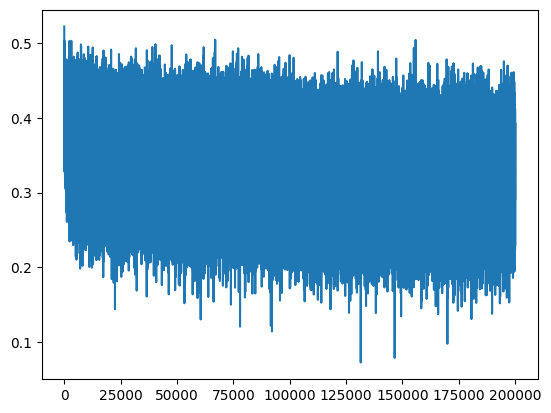

In [8]:
plt.plot(range(len(lossvals)), lossvals);

In [10]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # Apply batch norm
    #hpreact = bngain * (hpreact - hpreact.mean(axis=0, keepdim=True)) / hpreact.std(axis=0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h1 = torch.tanh(hpreact)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f'{split}, loss={loss.item()}')
    return loss.item()

split_loss('train')
split_loss('val')

train, loss=2.0673649311065674
val, loss=2.109304666519165


2.109304666519165

## Summary + Pytorchyfying the code

In [11]:
class Linear():
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1d():
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.Training = True
        self.momentum = momentum
        # Batch norm params (trainable)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # batch norm running mean and var: buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.Training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.Training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [12]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(416)
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden, bias=True), Tanh(),
    Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=True), BatchNorm1d(vocab_size),
    
]

with torch.no_grad():
    # make last layer less confident 
    layers[-1].gamma *= 0.1 # when the last layer is BatchNorm
    #layers[-1].weights *= 0.1  # When last layer is Linear
    # all other layers: apply gain
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weights *= 1.0 #5/3.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total parameters: {sum([p.nelement() for p in parameters])}")
for p in parameters:
    p.requires_grad = True

Total parameters: 47351


In [13]:
# Run the optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # DEBUG purpose. to visualize the gradients
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr
    
    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item(): .4f}")
    lossi.append(loss.log10().item())
    ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    #if i > 1000:
    #    break # for debugging


      0/ 200000:  3.2972
  10000/ 200000:  2.1552
  20000/ 200000:  2.5689
  30000/ 200000:  2.2082
  40000/ 200000:  2.2180
  50000/ 200000:  1.9740
  60000/ 200000:  2.1760
  70000/ 200000:  2.0971
  80000/ 200000:  1.8908
  90000/ 200000:  1.9130
 100000/ 200000:  2.2696
 110000/ 200000:  1.9187
 120000/ 200000:  2.2480
 130000/ 200000:  2.1405
 140000/ 200000:  1.6235
 150000/ 200000:  2.0409
 160000/ 200000:  2.4250
 170000/ 200000:  2.0933
 180000/ 200000:  1.9546
 190000/ 200000:  1.8908


layer 1 (      Tanh): mean -0.03, std 0.87, saturated: 48.69%
layer 4 (      Tanh): mean +0.00, std 0.70, saturated: 17.62%
layer 7 (      Tanh): mean -0.03, std 0.75, saturated: 17.28%
layer 10 (      Tanh): mean -0.01, std 0.77, saturated: 15.28%
layer 13 (      Tanh): mean +0.02, std 0.78, saturated: 16.69%


Text(0.5, 1.0, 'activation distribution')

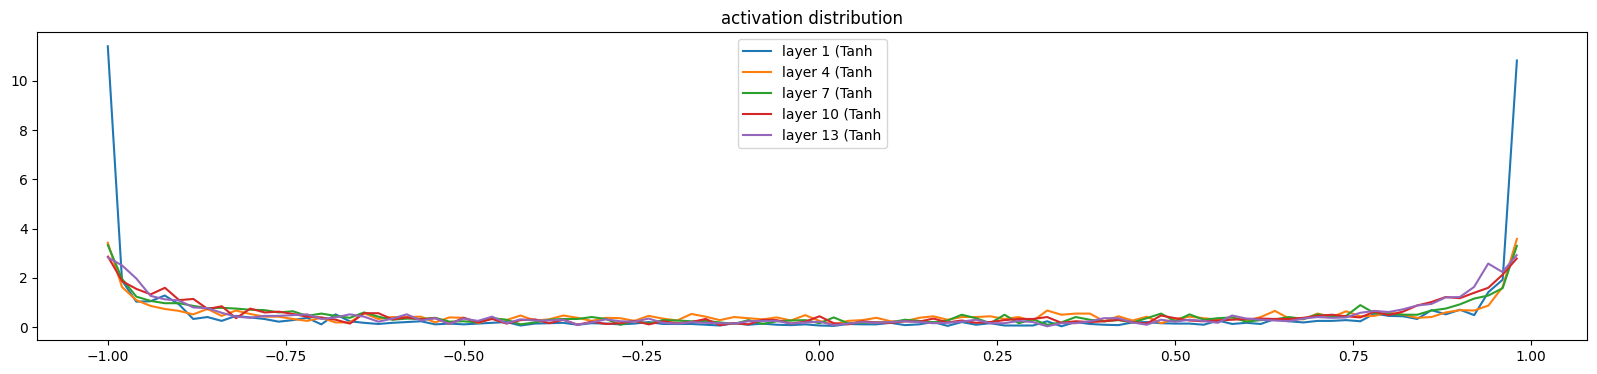

In [14]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000000, std 4.605864e-03
layer 4 (      Tanh): mean -0.000000, std 3.487570e-03
layer 7 (      Tanh): mean -0.000000, std 3.274138e-03
layer 10 (      Tanh): mean -0.000000, std 3.099547e-03
layer 13 (      Tanh): mean -0.000000, std 3.215723e-03


Text(0.5, 1.0, 'gradient distribution')

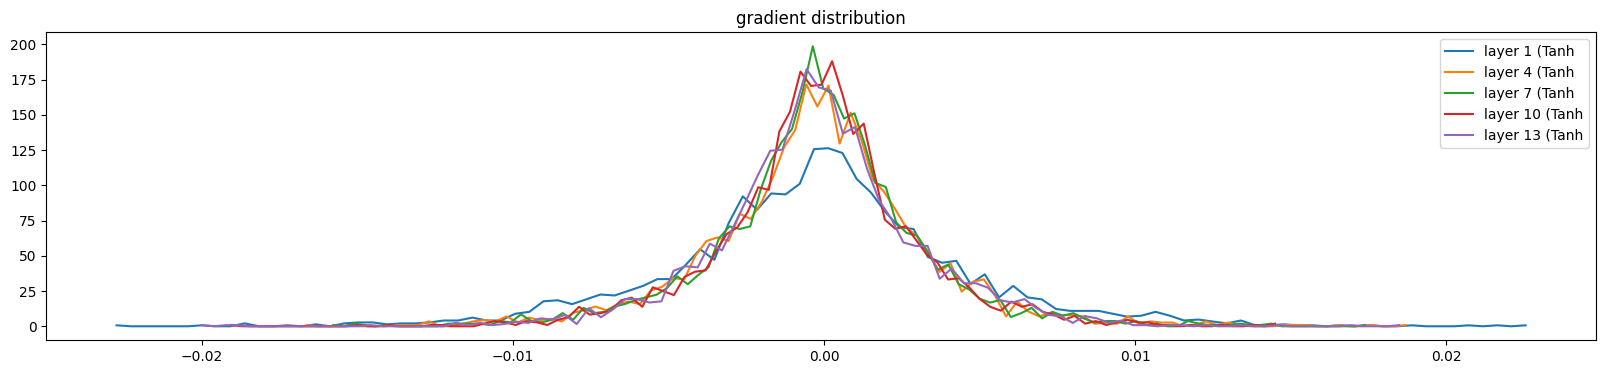

In [15]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000113 | std 1.288864e-02 | grad:data ratio 1.037710e-02
weight  (30, 100) | mean -0.000167 | std 1.022535e-02 | grad:data ratio 2.483698e-02
weight (100, 100) | mean -0.000012 | std 6.648306e-03 | grad:data ratio 2.930930e-02
weight (100, 100) | mean -0.000022 | std 5.773465e-03 | grad:data ratio 2.778880e-02
weight (100, 100) | mean -0.000094 | std 5.143153e-03 | grad:data ratio 2.621158e-02
weight (100, 100) | mean +0.000065 | std 4.653921e-03 | grad:data ratio 2.496704e-02
weight  (100, 27) | mean +0.000027 | std 6.449185e-03 | grad:data ratio 2.110289e-02


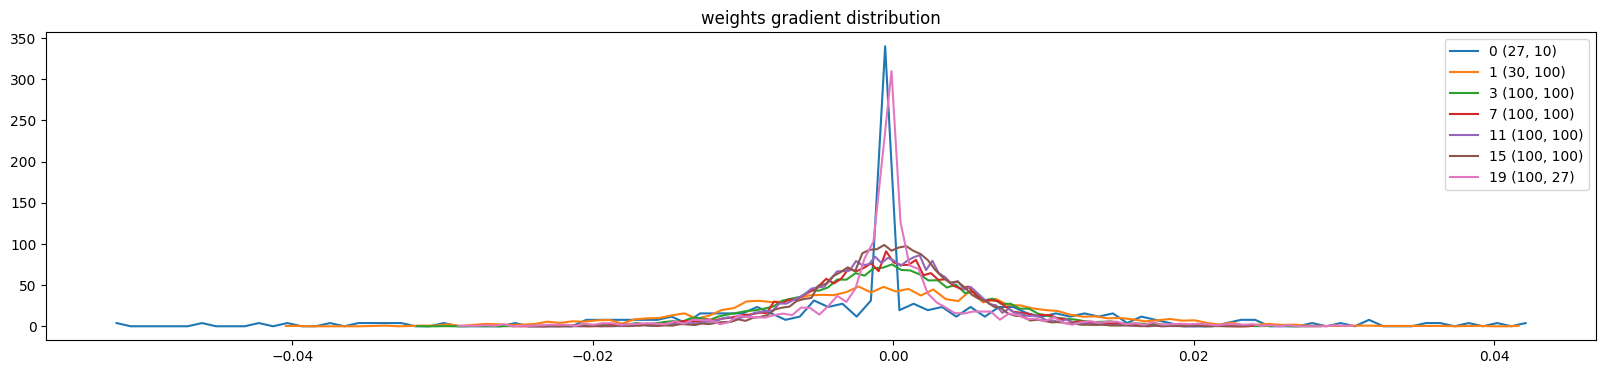

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

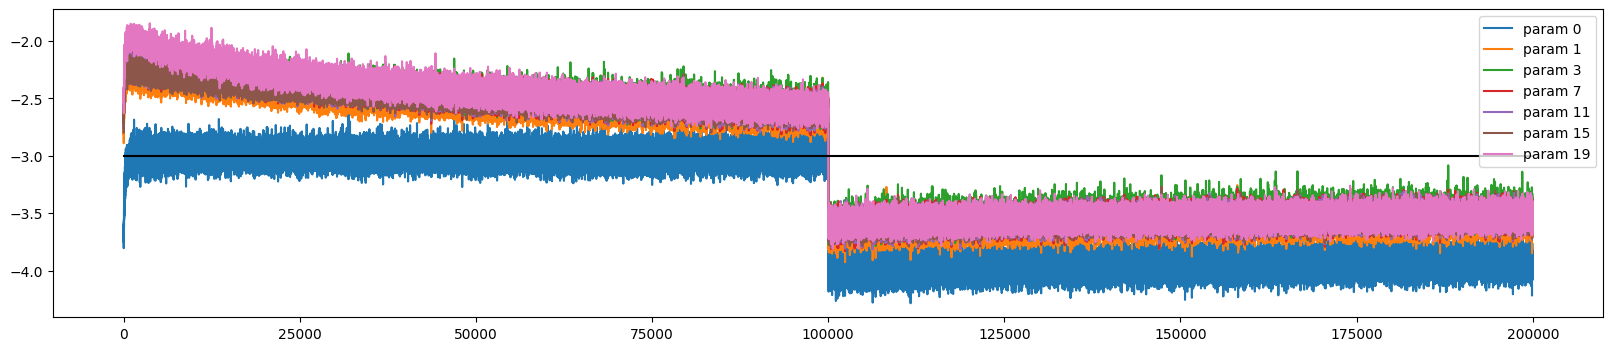

In [17]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [18]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y)
    print(f'{split}, loss={loss.item()}')
    return loss.item()

# Put layers into eval mode
for layer in layers:
    layer.Training = False
split_loss('train')
split_loss('val')

train, loss=2.000669002532959
val, loss=2.082796096801758


2.082796096801758

In [20]:
# sample from the model
g = torch.Generator().manual_seed(214748364 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word
    #break

nor.
sandhima.
codora.
ron.
oluwa.
alayna.
elmarcienna.
witauriah.
heen.
gracefuan.
rus.
alayaan.
dejosmnoransi.
ane.
liyah.
jose.
shanardo.
tilla.
fai.
louke.


In [21]:
# DONE; BONUS content below, not covered in video

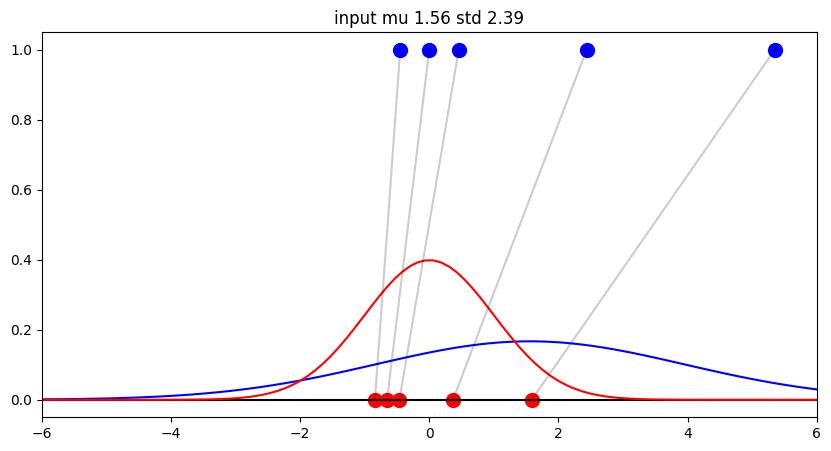

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [22]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
    g = torch.Generator().manual_seed(2147483647+1)
    x = torch.randn(5, generator=g) * 5
    x[0] = x0 # override the 0th example with the slider
    mu = x.mean()
    sig = x.std()
    y = (x - mu)/sig

    plt.figure(figsize=(10, 5))
    # plot 0
    plt.plot([-6,6], [0,0], 'k')
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
    plt.xlim(-6, 6)
    # title
    plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

In [23]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [26]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
